In [41]:
from google.colab import files
uploaded = files.upload()

Saving cd_mumbai_complaints.csv to cd_mumbai_complaints (3).csv


In [42]:
print (uploaded['cd_mumbai_complaints.csv'][:200].decode('utf-8') + '...')

generic_id,created_at,complaint_status_id,voteup_count,city_id,ward_id,category_id,sub_category_id,civic_agency_id,title,description,location
W01730C147452,"We are facing multiple issues related to r...


**Number of complaints in each class**

In [43]:
import pandas as pd
import io
df = pd.read_csv(io.StringIO(uploaded['cd_mumbai_complaints.csv'].decode('utf-8')))
df.head()
# df = pd.read_csv(io.StringIO(uploaded['cd_mumbai_complaints.csv'].decode('utf-8')))

,generic_id,created_at,complaint_status_id,voteup_count,city_id,ward_id,category_id,sub_category_id,civic_agency_id,title,description,location
0,W01730C147452,We are facing multiple issues related to road ...,4,28,2,946,15.0,66,22.0,8/5/16 9:45,"Potholes, Illegal Parking and Movement of Heav...","NSS Palkar Road, Asalfa Village, Ghatkopar Wes..."
1,W0960C153580,This is a really bad road. we need it cleaned ...,4,2,2,943,6.0,155,22.0,5/6/16 17:11,Bad road now with garbage,"21st Rd, MIDC Industrial Estate, Pandit Dinday..."
2,W01760C153649,This needs to be fixed asap.,2,40,2,946,21.0,84,25.0,5/6/16 21:16,Traffic issue that needs immediate attention,"5, JVLR, IIT Area, Powai, Mumbai, Maharashtra ..."
3,W01590C157072,We observed frequently heavy traffic at dahisa...,2,7,2,933,21.0,84,25.0,16-06-2016 19:42,Traffic jam at Dahisar check naka,"Western Express Hwy, Diamond Industrial Estate..."
4,W02080C164464,A pothole in front of Chand Shahwli Baba Darga...,3,19079,2,945,15.0,66,22.0,13-07-2016 12:57,Pothole on Pipeline Road,"Pipe Line Rd, Powai, IIT Area, Powai, Mumbai, ..."


We will be using category_id instead of the category because categorical variables are better represented by integers than strings

After Cleaning up, the first three rows of the data we will be working on:

In [44]:
df = df.dropna()
df

,generic_id,created_at,complaint_status_id,voteup_count,city_id,ward_id,category_id,sub_category_id,civic_agency_id,title,description,location
0,W01730C147452,We are facing multiple issues related to road ...,4,28,2,946,15.0,66,22.0,8/5/16 9:45,"Potholes, Illegal Parking and Movement of Heav...","NSS Palkar Road, Asalfa Village, Ghatkopar Wes..."
1,W0960C153580,This is a really bad road. we need it cleaned ...,4,2,2,943,6.0,155,22.0,5/6/16 17:11,Bad road now with garbage,"21st Rd, MIDC Industrial Estate, Pandit Dinday..."
2,W01760C153649,This needs to be fixed asap.,2,40,2,946,21.0,84,25.0,5/6/16 21:16,Traffic issue that needs immediate attention,"5, JVLR, IIT Area, Powai, Mumbai, Maharashtra ..."
3,W01590C157072,We observed frequently heavy traffic at dahisa...,2,7,2,933,21.0,84,25.0,16-06-2016 19:42,Traffic jam at Dahisar check naka,"Western Express Hwy, Diamond Industrial Estate..."
4,W02080C164464,A pothole in front of Chand Shahwli Baba Darga...,3,19079,2,945,15.0,66,22.0,13-07-2016 12:57,Pothole on Pipeline Road,"Pipe Line Rd, Powai, IIT Area, Powai, Mumbai, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
9293,W09460C398356,Garbage on foot path,1,0,2,946,6.0,155,22.0,8/9/18 11:11,Garbage on foot path,"Wing-B, Chandivali Rd, Yadav Nagar, Chandivali..."
9294,W09460C398357,Garbage near foot path,1,0,2,946,6.0,155,22.0,8/9/18 11:12,Garbage near foot path,"Manubhai Seetal Chawl, Chandivali Rd, Yadav Na..."
9295,W09550C398400,Please add sound barrier Along all the suburba...,1,0,2,955,313.0,314,28.0,8/9/18 12:37,Please add sound barrier Along all the suburba...,"Planet Godrej, Jacob Circle, Mumbai, Maharasht..."
9296,W09440C398666,Garbage on foot path,1,0,2,944,6.0,155,22.0,9/9/18 8:31,Garbage on foot path,"D-2, Pandit Madan Mohan Malaviya Rd, Mtnl Colo..."


In [45]:
from io import StringIO
col = ['category_id', 'description']
df = df[col]
df = df[pd.notnull(df['description'])]
df.columns = ['category_id', 'description']
df['category_id_val'] = df['category_id']
df["category_id_val"] = df["category_id_val"].astype(int)
category_id_df = df[['category_id', 'category_id_val']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id_val', 'category_id']].values)
df

,category_id,description,category_id_val
0,15.0,"Potholes, Illegal Parking and Movement of Heav...",15
1,6.0,Bad road now with garbage,6
2,21.0,Traffic issue that needs immediate attention,21
3,21.0,Traffic jam at Dahisar check naka,21
4,15.0,Pothole on Pipeline Road,15
...,...,...,...
9293,6.0,Garbage on foot path,6
9294,6.0,Garbage near foot path,6
9295,313.0,Please add sound barrier Along all the suburba...,313
9296,6.0,Garbage on foot path,6


The number of complaints per category is imbalanced.
To have imbalanced data in our case might be of our great interest. Since, it is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes.

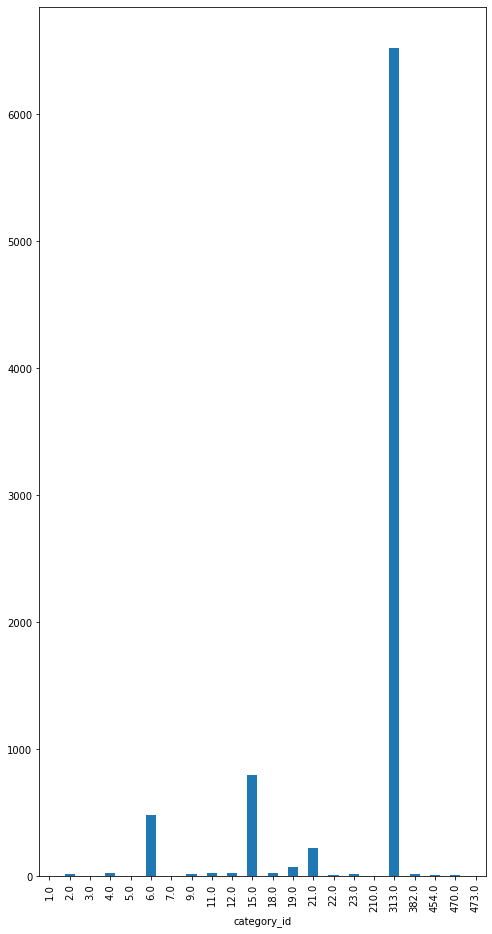

In [46]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,16))
df.groupby('category_id').description.count().plot.bar(ylim=0)
plt.show()

Here, our approach for extracting features from text is that we are using bag of words model:a model where for each document, a category in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.description).toarray()
labels = df.category_id
features.shape

(8337, 571)

We can use *sklearn.feature_selection.chi2* to find the terms that are the most correlated with each of the complaint.

In [48]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for category_id, category_id_val in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category_id))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '1.0':
  . Most correlated unigrams:
. station
. badly
  . Most correlated bigrams:
. road station
. badly maintained
# '2.0':
  . Most correlated unigrams:
. menace
. public
  . Most correlated bigrams:
. public toilet
. main road
# '3.0':
  . Most correlated unigrams:
. high
. illegal
  . Most correlated bigrams:
. road station
. badly maintained
# '4.0':
  . Most correlated unigrams:
. cut
. electricity
  . Most correlated bigrams:
. street lights
. lights working
# '5.0':
  . Most correlated unigrams:
. badly
. mumbai
  . Most correlated bigrams:
. road station
. badly maintained
# '6.0':
  . Most correlated unigrams:
. dump
. garbage
  . Most correlated bigrams:
. complaint garbage
. garbage dump
# '7.0':
  . Most correlated unigrams:
. left
. thrown
  . Most correlated bigrams:
. badly maintained
. garbage thrown
# '9.0':
  . Most correlated unigrams:
. spitting
. truck
  . Most correlated bigrams:
. mankhurd station
. east station
# '11.0':
  . Most correlated unigrams:
. poll

In [49]:
df['category_id'].unique()


array([ 15.,   6.,  21.,  23.,  19.,  11.,  12.,   3., 382.,   4.,  22.,
         9., 313.,   2., 454.,  18.,   7.,   1., 210., 470., 473.,   5.])

After all the above data transformation, now that we have all the features and labels, it is time to train the classifiers. There are a number of algorithms we can use for this type of problem.
* **Naive Bayes Classifier:** the one most 
suitable for word counts is the multinomial variant:





In [50]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['category_id'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)


**We can also experiment with different machine learning models**, evaluate their accuracy and find the source of any potential issues.
We can benchmark the following four models:
* Logistic Regression
* (Multinomial) Naive Bayes
* Linear Support Vector Machine
* Random Forest

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


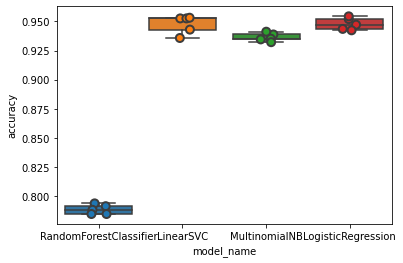

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [52]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.947462
LogisticRegression        0.947942
MultinomialNB             0.936428
RandomForestClassifier    0.788532
Name: accuracy, dtype: float64

Continue with our best model (LinearSVC), we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

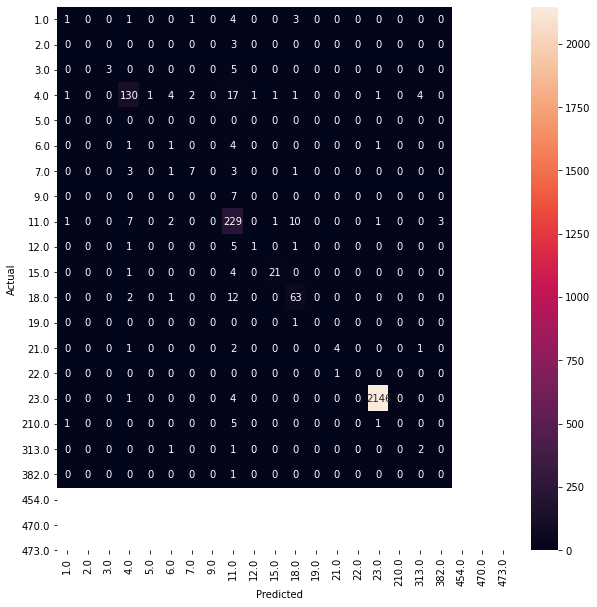

In [53]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category_id.values, yticklabels=category_id_df.category_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [54]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [55]:
from google.colab import files
uploaded = files.upload()

Saving cd_categories.csv to cd_categories (1).csv


Importing the *cd_categories.csv* file so that we can map the categories with category_id

In [56]:
import pandas as pd
import io
df_category = pd.read_csv(io.StringIO(uploaded['cd_categories.csv'].decode('utf-8')))
df_category.head()

,id,title,parent_id
0,1,Certificates,0
1,2,Crime and Safety,0
2,4,Electricity and Power Supply,0
3,5,Fire Safety,0
4,6,Garbage and Unsanitary Practices,0


In [58]:
texts = ["lightning eletric shock"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(df_category[df_category['id']==int(id_to_category[predicted])]['title'].values ))
  print("")

"lightning eletric shock"
  - Predicted as: '['Mobility - Roads, Footpaths and Infrastructure']'

